In [ ]:
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

In [ ]:
# --- LOAD YAHOO ANSWERS TOPICS DATASET ---
topics_data = load_dataset("yahoo_answers_topics")
answers_df = pd.concat([pd.DataFrame(topics_data['train']), pd.DataFrame(topics_data['test'])], ignore_index=True)
answers_df = answers_df.sample(frac=1, random_state=123).reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [ ]:
# --- SUBSAMPLE FOR DEMO ---
df_main, df_eval = train_test_split(
    answers_df, train_size=6000, test_size=1000, stratify=answers_df['topic'], random_state=123
)

In [ ]:
topic_names = [
    "Society & Culture", "Science & Mathematics", "Health", "Education & Reference",
    "Computers & Internet", "Sports", "Business & Finance", "Entertainment & Music",
    "Family & Relationships", "Politics & Government"
]

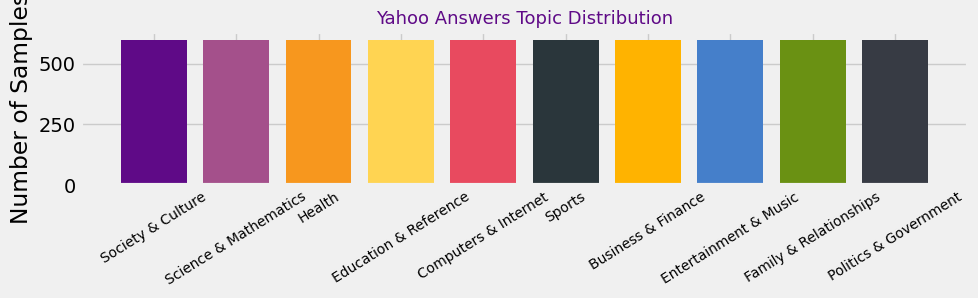

In [ ]:
# --- LABEL DISTRIBUTION ---
plt.figure(figsize=(10,3.2))
plt.bar(topic_names, df_main['topic'].value_counts().sort_index(), color=[
    '#5f0a87', '#a4508b', '#f7971e', '#ffd452', '#e84a5f', '#2a363b', '#ffb300', '#457fca', '#6a9113', '#373b44'
])
plt.title('Yahoo Answers Topic Distribution', fontsize=13, color='#5f0a87')
plt.ylabel('Number of Samples')
plt.xticks(rotation=32, fontsize=10)
plt.tight_layout()
plt.show()

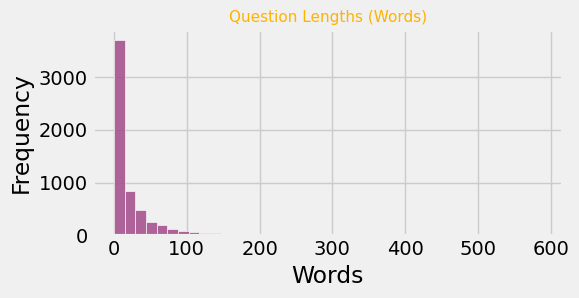

In [ ]:
# --- TEXT LENGTH HIST ---
df_main['q_len'] = df_main['question_content'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,3.2))
plt.hist(df_main['q_len'], bins=40, color='#a4508b', edgecolor='#fff', alpha=0.88)
plt.title('Question Lengths (Words)', fontsize=11, color='#ffb300')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

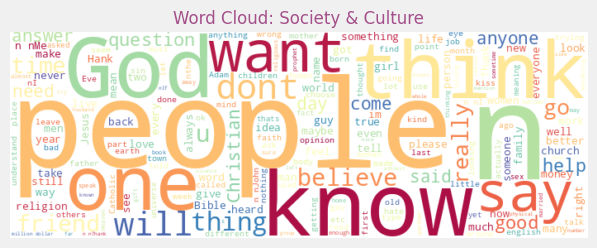

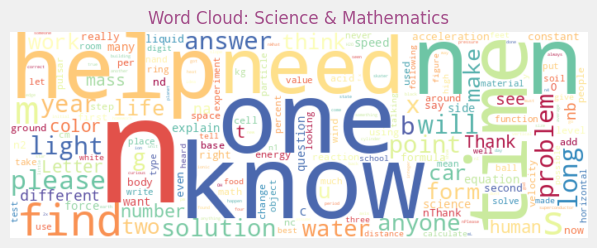

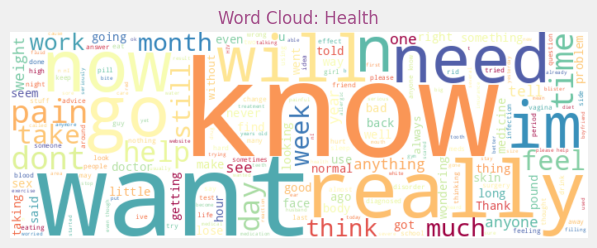

In [ ]:
# --- WORD CLOUDS FOR TOP 3 CLASSES ---
for idx in [0, 1, 2]:
    q_text = " ".join(df_main[df_main['topic'] == idx]['question_content'])
    wc = WordCloud(width=700, height=250, background_color='white', colormap='Spectral').generate(q_text)
    plt.figure(figsize=(7,2.7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud: {topic_names[idx]}", fontsize=12, color='#a4508b')
    plt.tight_layout()
    plt.show()

In [ ]:
# --- BERT TOKENIZER, DATASET, AND DATALOADER ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
maxlen = 48

class YahooTopicDataset(Dataset):
    def __init__(self, question_list, label_list, tokenizer, maxlen):
        self.question_list = question_list
        self.label_list = label_list
        self.tokenizer = tokenizer
        self.maxlen = maxlen
    def __len__(self): return len(self.question_list)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.question_list[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.maxlen,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.label_list[idx], dtype=torch.long)
        return item

train_data = YahooTopicDataset(
    df_main['question_content'].tolist(), df_main['topic'].tolist(), tokenizer, maxlen)
test_data = YahooTopicDataset(
    df_eval['question_content'].tolist(), df_eval['topic'].tolist(), tokenizer, maxlen)

train_loader = DataLoader(train_data, batch_size=22, shuffle=True)
test_loader = DataLoader(test_data, batch_size=22)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# --- MODEL SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
topic_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
topic_model = topic_model.to(device)
optimizer = AdamW(topic_model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Loss: 2.0738
Epoch 2 | Loss: 1.6860
Epoch 3 | Loss: 1.4775
Epoch 4 | Loss: 1.3274
Epoch 5 | Loss: 1.2257
Epoch 6 | Loss: 1.1612
Epoch 7 | Loss: 1.1192
Epoch 8 | Loss: 1.0991
Epoch 9 | Loss: 1.0888
Epoch 10 | Loss: 1.0903
Epoch 11 | Loss: 1.0832
Epoch 12 | Loss: 1.0852
Epoch 13 | Loss: 1.0736
Epoch 14 | Loss: 1.0789
Epoch 15 | Loss: 1.0820
Epoch 16 | Loss: 1.0799
Epoch 17 | Loss: 1.0788
Epoch 18 | Loss: 1.0738
Epoch 19 | Loss: 1.0765
Epoch 20 | Loss: 1.0682


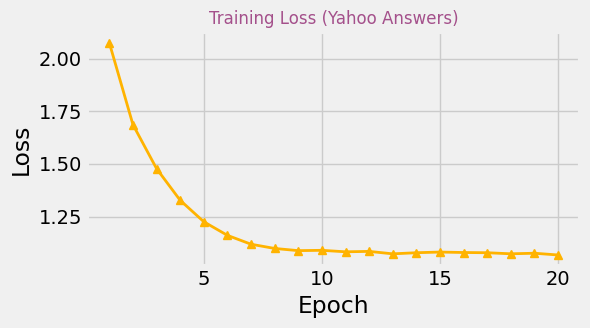

In [ ]:
# --- TRAINING LOOP ---
epochs = 20
loss_vals = []
topic_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labs = batch['labels'].to(device)
        optimizer.zero_grad()
        outs = topic_model(input_ids=ids, attention_mask=mask, labels=labs)
        loss = outs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg:.4f}")
    loss_vals.append(avg)

plt.figure(figsize=(6,3.5))
plt.plot(range(1, epochs+1), loss_vals, marker='^', color='#ffb300', linewidth=2)
plt.title('Training Loss (Yahoo Answers)', fontsize=12, color='#a4508b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


Test Accuracy: 0.3980
Test F1 Score: 0.4256


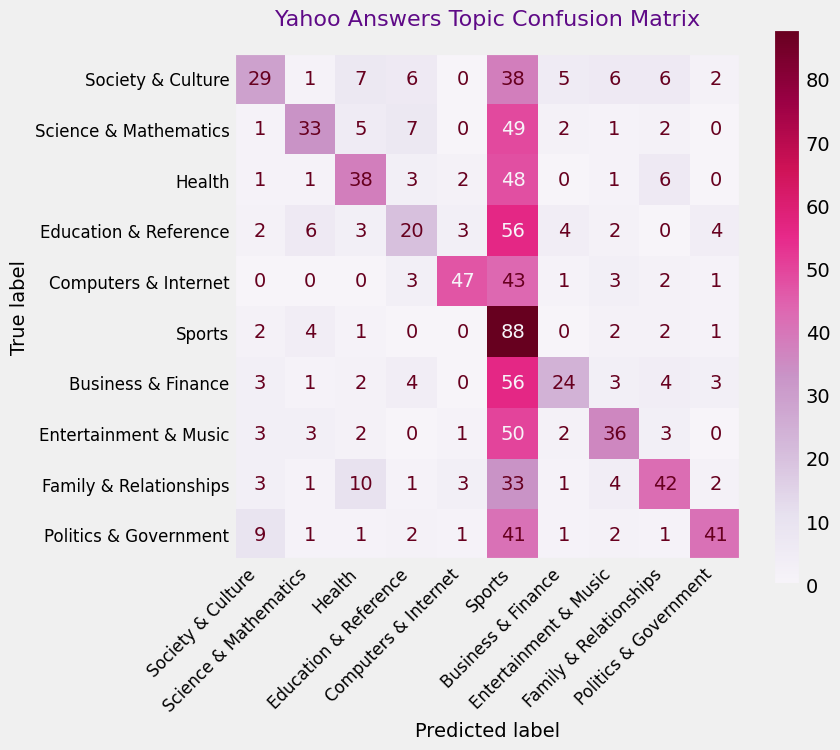

In [ ]:
# --- EVALUATE ---
topic_model.eval()
preds, trues = [], []
with torch.no_grad():
    for batch in test_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labs = batch['labels'].to(device)
        outs = topic_model(input_ids=ids, attention_mask=mask)
        pred = torch.argmax(outs.logits, dim=1)
        preds.extend(pred.cpu().numpy())
        trues.extend(labs.cpu().numpy())
acc = accuracy_score(trues, preds)
f1 = f1_score(trues, preds, average='weighted')
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")

cm = confusion_matrix(trues, preds)
fig, ax = plt.subplots(figsize=(9, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=topic_names)

# Custom colormap (any matplotlib cmap, or try 'PuRd', 'plasma', 'Blues', etc.)
disp.plot(cmap='PuRd', ax=ax, colorbar=True, values_format='d')

# Make tick labels readable
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add a grid, custom title, and tighten layout
plt.grid(False)
plt.title('Yahoo Answers Topic Confusion Matrix', fontsize=16, color='#5f0a87', pad=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- SAMPLE PREDICTIONS ---
print("\nSample predictions:\n")
for i in range(5):
    print(f"Question: {df_eval['question_content'].tolist()[i][:100]}...")
    print(f"True: {topic_names[df_eval['topic'].tolist()[i]]} | Predicted: {topic_names[preds[i]]}\n")


Sample predictions:

Question: http://i43.photobucket.com/albums/e397/Bigpappadiaz/cydred.jpg\n\nMany, many years ago Mars had life...
True: Society & Culture | Predicted: Science & Mathematics

Question: what about your friends?...
True: Politics & Government | Predicted: Society & Culture

Question: I've been playing in-line hockey for 6 years, and I think I'm pretty decent. I've never played ice b...
True: Sports | Predicted: Sports

Question: when travelling?...
True: Computers & Internet | Predicted: Education & Reference

Question: pod problem of the day...
True: Science & Mathematics | Predicted: Science & Mathematics

